라이브러리

In [40]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name = 'rereredoRegressor_tank1dofood4'

In [41]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [42]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [43]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [44]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [45]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [46]:
japonica_training_features_X = japonica_training_data[['do_mg','feed_quantity']]

japonica_validation_features_X = japonica_validation_data[['do_mg', 'feed_quantity']]

In [47]:
japonica_training_features_y = japonica_training_features_X[['do_mg']]

japonica_validation_features_y = japonica_validation_features_X[['do_mg']]

In [48]:
japonica_training_features_X_chunks = []
japonica_training_features_y_chunks = []

for i in range(0, len(japonica_training_features_X) - 179):
    japonica_training_features_X_chunks.append(np.array(japonica_training_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_X_chunks = np.array(japonica_training_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_training_features_y) - 179):
    japonica_training_features_y_chunks.append(np.array(japonica_training_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_y_chunks = np.array(japonica_training_features_y_chunks, dtype=np.float64)

In [49]:
japonica_validation_features_X_chunks = []
japonica_validation_features_y_chunks = []


for i in range(0, len(japonica_validation_features_X) - 179):
    japonica_validation_features_X_chunks.append(np.array(japonica_validation_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_X_chunks = np.array(japonica_validation_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_validation_features_y) - 179):
    japonica_validation_features_y_chunks.append(np.array(japonica_validation_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_y_chunks = np.array(japonica_validation_features_y_chunks, dtype=np.float64)

japonica_validation_features_X_chunks = []
japonica_validation_features_y_chunks = []


for i in range(0, len(japonica_validation_features_X) - 179):
    japonica_validation_features_X_chunks.append(np.array(japonica_validation_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_X_chunks = np.array(japonica_validation_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_validation_features_y) - 179):
    japonica_validation_features_y_chunks.append(np.array(japonica_validation_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_y_chunks = np.array(japonica_validation_features_y_chunks, dtype=np.float64)

In [50]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64621 nVar: 2
nCar: 64621 nVar: 180
nCar: 64621 nVar: 2
nCar: 64621 nVar: 180


In [51]:
japonica_training_features_X_chunks_crop = japonica_training_features_X_chunks[:-180]
japonica_training_features_y_chunks_crop = japonica_training_features_y_chunks[180:]

japonica_validation_features_X_chunks_crop = japonica_validation_features_X_chunks[:-180]
japonica_validation_features_y_chunks_crop = japonica_validation_features_y_chunks[180:]

In [52]:
nCar = japonica_training_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64441 nVar: 2
nCar: 64441 nVar: 180
nCar: 64441 nVar: 2
nCar: 64441 nVar: 180


In [53]:
japonica_training_features_X_chunks_crop_a = japonica_training_features_X_chunks_crop[:, :, 0].reshape((-1, 180, 1))
japonica_training_features_X_chunks_crop_b = japonica_training_features_X_chunks_crop[:, :, 1].reshape((-1, 180, 1))

japonica_validation_features_X_chunks_crop_a = japonica_validation_features_X_chunks_crop[:, :, 0].reshape((-1, 180, 1))
japonica_validation_features_X_chunks_crop_b = japonica_validation_features_X_chunks_crop[:, :, 1].reshape((-1, 180, 1))

In [54]:
nCar = japonica_training_features_X_chunks_crop_a.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop_a.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_X_chunks_crop_b.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop_b.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop_a.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop_a.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop_b.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop_b.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64441 nVar: 1
nCar: 64441 nVar: 180
nCar: 64441 nVar: 1
nCar: 64441 nVar: 180


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [55]:
# 첫 번째 입력: A 피처
input_a = Input(shape=(180, 1))
lstm_a = LSTM(128)(input_a)

# 두 번째 입력: B 피처
input_b = Input(shape=(180, 1))
lstm_b = LSTM(64)(input_b)

# A와 B의 출력을 결합
concatenated = concatenate([lstm_a, lstm_b])

# 출력층 추가
output = Dense(180, activation='linear')(concatenated)

# Multi-Input 모델 구성
model = Model(inputs=[input_a, input_b], outputs=output)
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit([japonica_training_features_X_chunks_crop_a, japonica_training_features_X_chunks_crop_b], japonica_training_features_y_chunks_crop, epochs = 200, batch_size = 32, validation_data=([japonica_validation_features_X_chunks_crop_a, japonica_validation_features_X_chunks_crop_b], japonica_validation_features_y_chunks_crop), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 180, 1)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 180, 1)]     0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 128)          66560       input_3[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 64)           16896       input_4[0][0]                    
______________________________________________________________________________________________

2023-07-10 17:31:53.120309: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2023-07-10 17:31:56.879099: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-07-10 17:31:57.897511: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2014/2014 [==============================] - 82s 38ms/step - loss: 1.4407 - mae: 0.6365 - r_squared: -0.0839 - val_loss: 0.3642 - val_mae: 0.3896 - val_r_squared: -2.7115
Epoch 2/200
2014/2014 [==============================] - 76s 38ms/step - loss: 0.3653 - mae: 0.3912 - r_squared: 0.7334 - val_loss: 0.3528 - val_mae: 0.3761 - val_r_squared: -2.1011
Epoch 3/200
2014/2014 [==============================] - 76s 38ms/step - loss: 0.3597 - mae: 0.3840 - r_squared: 0.7372 - val_loss: 0.4720 - val_mae: 0.5098 - val_r_squared: -6.0214
Epoch 4/200
2014/2014 [==============================] - 75s 37ms/step - loss: 0.3597 - mae: 0.3843 - r_squared: 0.7372 - val_loss: 0.3611 - val_mae: 0.3967 - val_r_squared: -2.6405
Epoch 5/200
1703/2014 [========================>.....] - ETA: 8s - loss: 0.3406 - mae: 0.3713 - r_squared: 0.7522

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 76s 38ms/step - loss: 0.2947 - mae: 0.3523 - r_squared: 0.7847 - val_loss: 0.3000 - val_mae: 0.3580 - val_r_squared: -2.5874
Epoch 14/200
2014/2014 [==============================] - 75s 37ms/step - loss: 0.2937 - mae: 0.3529 - r_squared: 0.7844 - val_loss: 0.2843 - val_mae: 0.3525 - val_r_squared: -2.1821
Epoch 15/200
2014/2014 [==============================] - 76s 38ms/step - loss: 0.2864 - mae: 0.3481 - r_squared: 0.7893 - val_loss: 0.2778 - val_mae: 0.3395 - val_r_squared: -1.8996

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 16/200
1917/2014 [===========================>..] - ETA: 2s - loss: 0.2666 - mae: 0.3345 - r_squared: 0.8033

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 76s 38ms/step - loss: 0.2529 - mae: 0.3288 - r_squared: 0.8134 - val_loss: 0.2452 - val_mae: 0.3266 - val_r_squared: -1.7207
Epoch 26/200
2014/2014 [==============================] - 76s 38ms/step - loss: 0.2518 - mae: 0.3280 - r_squared: 0.8137 - val_loss: 0.2639 - val_mae: 0.3305 - val_r_squared: -1.6724
Epoch 27/200
2014/2014 [==============================] - 76s 38ms/step - loss: 0.2483 - mae: 0.3268 - r_squared: 0.8162 - val_loss: 0.2460 - val_mae: 0.3259 - val_r_squared: -1.8278
Epoch 28/200
 803/2014 [==========>...................] - ETA: 30s - loss: 0.2528 - mae: 0.3289 - r_squared: 0.8122

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 75s 37ms/step - loss: 0.2383 - mae: 0.3228 - r_squared: 0.8234 - val_loss: 0.2379 - val_mae: 0.3225 - val_r_squared: -1.6449
Epoch 36/200
2014/2014 [==============================] - 76s 38ms/step - loss: 0.2387 - mae: 0.3229 - r_squared: 0.8221 - val_loss: 0.2378 - val_mae: 0.3226 - val_r_squared: -1.6449
Epoch 37/200
2014/2014 [==============================] - 75s 37ms/step - loss: 0.2376 - mae: 0.3225 - r_squared: 0.8244 - val_loss: 0.2367 - val_mae: 0.3220 - val_r_squared: -1.6461
Epoch 38/200
2014/2014 [==============================] - 75s 37ms/step - loss: 0.2371 - mae: 0.3224 - r_squared: 0.8233 - val_loss: 0.2366 - val_mae: 0.3218 - val_r_squared: -1.6260
Epoch 39/200
 528/2014 [======>.......................] - ETA: 38s - loss: 0.2423 - mae: 0.3229 - r_squared: 0.8236

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 75s 37ms/step - loss: 0.2346 - mae: 0.3213 - r_squared: 0.8258 - val_loss: 0.2333 - val_mae: 0.3203 - val_r_squared: -1.5942
Epoch 47/200
2014/2014 [==============================] - 75s 37ms/step - loss: 0.2333 - mae: 0.3207 - r_squared: 0.8267 - val_loss: 0.2326 - val_mae: 0.3207 - val_r_squared: -1.6243
Epoch 48/200
2014/2014 [==============================] - 75s 37ms/step - loss: 0.2331 - mae: 0.3204 - r_squared: 0.8261 - val_loss: 0.2326 - val_mae: 0.3206 - val_r_squared: -1.6033
Epoch 49/200
2014/2014 [==============================] - 75s 37ms/step - loss: 0.2340 - mae: 0.3209 - r_squared: 0.8260 - val_loss: 0.2331 - val_mae: 0.3202 - val_r_squared: -1.6191
Epoch 50/200
 750/2014 [==========>...................] - ETA: 32s - loss: 0.2297 - mae: 0.3181 - r_squared: 0.8300

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 76s 38ms/step - loss: 0.2313 - mae: 0.3197 - r_squared: 0.8281 - val_loss: 0.2310 - val_mae: 0.3195 - val_r_squared: -1.5980
Epoch 59/200
2014/2014 [==============================] - 75s 37ms/step - loss: 0.2310 - mae: 0.3195 - r_squared: 0.8282 - val_loss: 0.2310 - val_mae: 0.3194 - val_r_squared: -1.6035
Epoch 00059: early stopping


모델 평가

In [56]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [57]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

In [58]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(2), weights[:, 0])
ax.set_xticks(range(2))
ax.set_xticklabels(['do_mg', 'feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

IndexError: list index out of range

In [59]:
japonica_validation_features_X

,do_mg,feed_quantity
mea_dt,,
2021-07-21 00:00:00,7.7,0.0
2021-07-21 00:01:00,7.8,0.0
2021-07-21 00:02:00,7.8,0.0
2021-07-21 00:03:00,7.8,0.0
2021-07-21 00:04:00,7.9,0.0
...,...,...
2021-09-08 23:55:00,8.7,0.0
2021-09-08 23:56:00,8.7,0.0
2021-09-08 23:57:00,8.7,0.0


In [71]:
X_test = japonica_validation_features_X.loc['2021-07-22 00:00':'2021-09-08 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

X_test_reshape_a = X_test_reshape[:, :, 0].reshape((-1, 180, 1))
X_test_reshape_b = X_test_reshape[:, :, 1].reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 351 nVar: 1
nCar: 351 nVar: 1


In [72]:
y_date = japonica_validation_features_X.loc['2021-07-22 03:00':'2021-09-08 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 63180 nVar: 1
nCar: 351 nVar: 180


63180


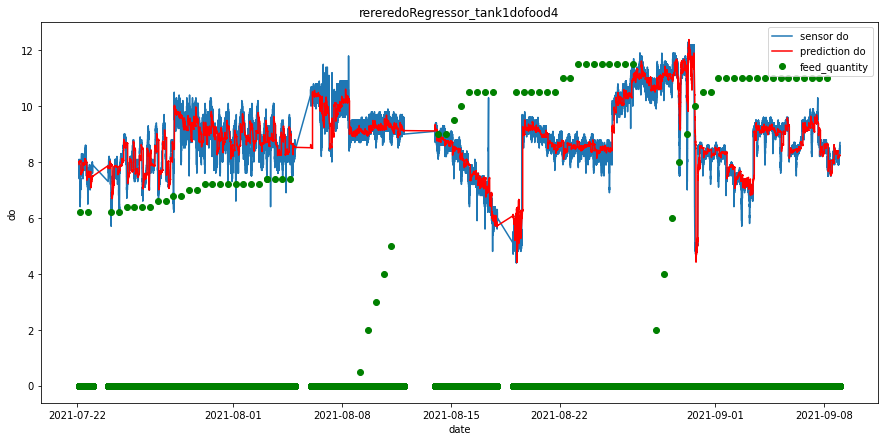

11/11 [==============================] - 1s 12ms/step - loss: 0.2743 - mae: 0.3339 - r_squared: 0.5242
MSE // MAE // R-squared  [0.2742525041103363, 0.3339081108570099, 0.5241615772247314]


In [73]:
grapeNEva(model,[X_test_reshape_a, X_test_reshape_b], y_test, y_date[['feed_quantity']], y_test_reshape)

In [74]:
X_test = japonica_validation_features_X.loc['2021-07-22 00:00':'2021-07-31 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

X_test_reshape_a = X_test_reshape[:, :, 0].reshape((-1, 180, 1))
X_test_reshape_b = X_test_reshape[:, :, 1].reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 71 nVar: 1
nCar: 71 nVar: 1


In [75]:
y_date = japonica_validation_features_X.loc['2021-07-22 03:00':'2021-07-31 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 12780 nVar: 1
nCar: 71 nVar: 180


12780


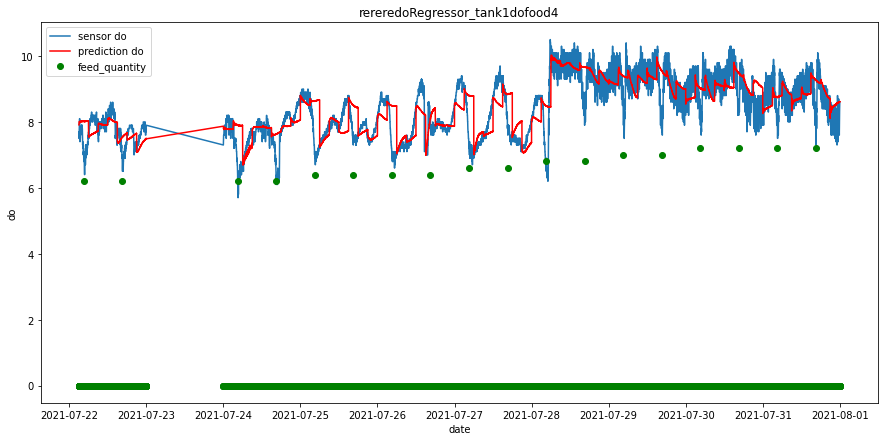

3/3 [==============================] - 0s 11ms/step - loss: 0.3393 - mae: 0.4282 - r_squared: 0.2238
MSE // MAE // R-squared  [0.33934924006462097, 0.42824405431747437, 0.22382225096225739]


In [76]:
grapeNEva(model,[X_test_reshape_a, X_test_reshape_b], y_test, y_date[['feed_quantity']], y_test_reshape)

In [77]:
X_test = japonica_validation_features_X.loc['2021-07-22 00:00':'2021-07-22 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

X_test_reshape_a = X_test_reshape[:, :, 0].reshape((-1, 180, 1))
X_test_reshape_b = X_test_reshape[:, :, 1].reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 7 nVar: 1
nCar: 7 nVar: 1


In [78]:
y_date = japonica_validation_features_X.loc['2021-07-22 03:00':'2021-07-22 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1260 nVar: 1
nCar: 7 nVar: 180


1260


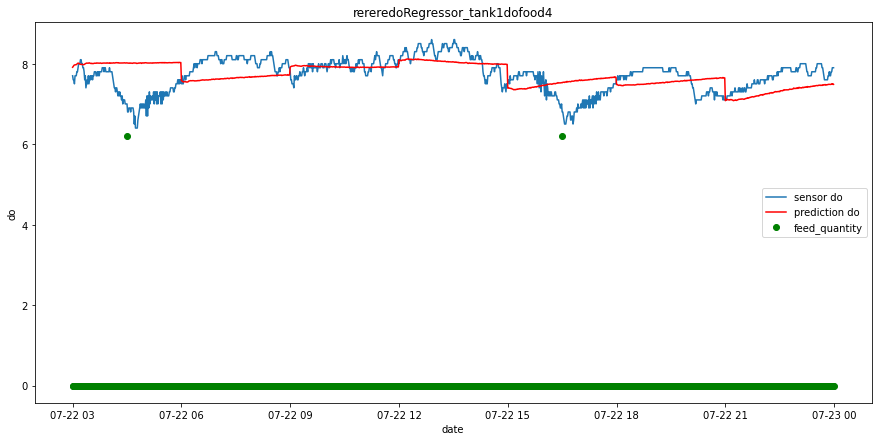

1/1 [==============================] - 0s 50ms/step - loss: 0.1989 - mae: 0.3651 - r_squared: -0.1111
MSE // MAE // R-squared  [0.1989389806985855, 0.36514562368392944, -0.11113202571868896]


In [79]:
grapeNEva(model,[X_test_reshape_a, X_test_reshape_b], y_test, y_date[['feed_quantity']], y_test_reshape)

In [80]:
X_test = japonica_validation_features_X.loc['2021-07-22 00:00':'2021-07-22 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

X_test_reshape_a = X_test_reshape[:, :, 0].reshape((-1, 180, 1))
X_test_reshape_b = X_test_reshape[:, :, 1].reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 1
nCar: 4 nVar: 1


In [81]:
y_date = japonica_validation_features_X.loc['2021-07-22 03:00':'2021-07-22 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 4 nVar: 180


720


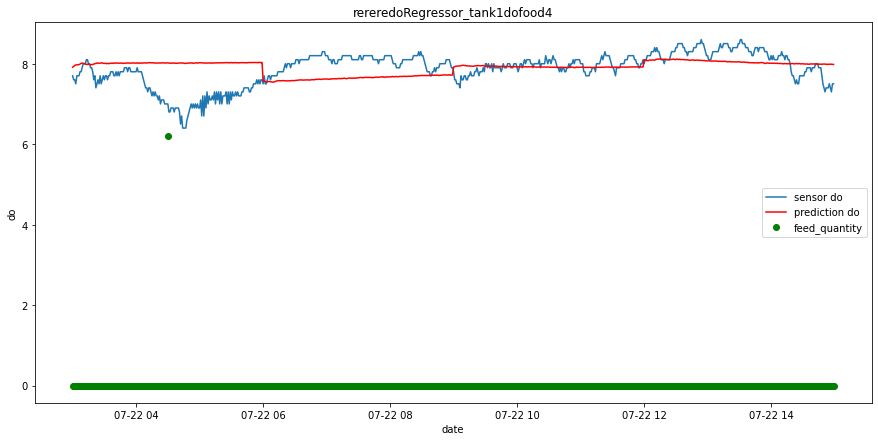

1/1 [==============================] - 0s 47ms/step - loss: 0.2226 - mae: 0.3632 - r_squared: -0.3098
MSE // MAE // R-squared  [0.2225954383611679, 0.3631581962108612, -0.3098278045654297]


In [82]:
grapeNEva(model,[X_test_reshape_a, X_test_reshape_b], y_test, y_date[['feed_quantity']], y_test_reshape)

In [83]:
japonica_validation_features_X.at['2021-07-22 08:00', 'feed_quantity'] = 6

X_test = japonica_validation_features_X.loc['2021-07-22 00:00':'2021-07-22 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

X_test_reshape_a = X_test_reshape[:, :, 0].reshape((-1, 180, 1))
X_test_reshape_b = X_test_reshape[:, :, 1].reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 1
nCar: 4 nVar: 1


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [84]:
y_date = japonica_validation_features_X.loc['2021-07-22 03:00':'2021-07-22 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 4 nVar: 180


720


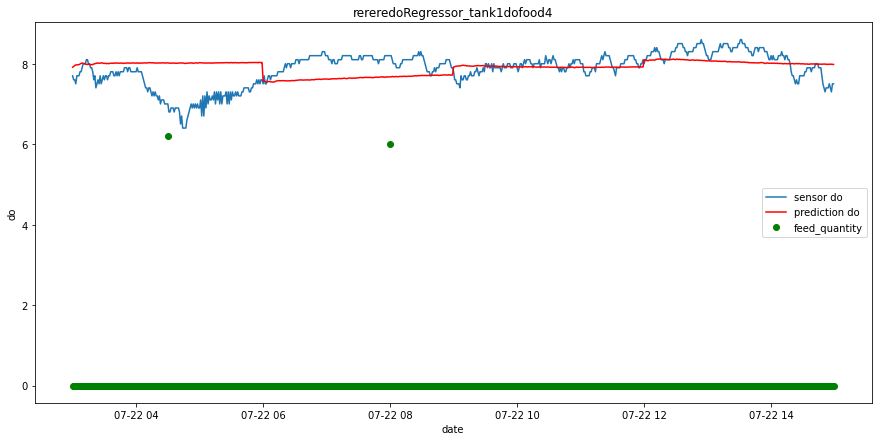

1/1 [==============================] - 0s 49ms/step - loss: 0.2226 - mae: 0.3632 - r_squared: -0.3098
MSE // MAE // R-squared  [0.2225954383611679, 0.3631581962108612, -0.3098278045654297]


In [85]:
grapeNEva(model,[X_test_reshape_a, X_test_reshape_b], y_test, y_date[['feed_quantity']], y_test_reshape)